In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [14]:
# We download the data from Yahoo Finance
appl_df = yf.download('VTI', start="2010-01-01", progress=False)

In [15]:
# We set up the Price column to be the next day's open price
appl_df['Price'] = appl_df.Open.shift(-1)

In [16]:
appl_df

,Open,High,Low,Close,Adj Close,Volume,Price
Date,,,,,,,
2010-01-04,56.860001,57.380001,56.840000,57.310001,44.335220,2251500,57.340000
2010-01-05,57.340000,57.540001,57.110001,57.529999,44.505428,1597700,57.500000
2010-01-06,57.500000,57.720001,57.410000,57.610001,44.567329,2120300,57.549999
2010-01-07,57.549999,57.889999,57.290001,57.849998,44.752983,1656700,57.700001
2010-01-08,57.700001,58.049999,57.560001,58.040001,44.899982,1650000,58.299999
...,...,...,...,...,...,...,...
2024-01-22,240.539993,241.399994,240.050003,240.580002,240.580002,3952700,241.020004
2024-01-23,241.020004,241.169998,240.059998,241.020004,241.020004,3015300,242.660004
2024-01-24,242.660004,242.869995,240.850006,240.979996,240.979996,3003000,242.190002


In [17]:
# We calculate the SMA (Simple Moving Average) for a given period
def calc_ma(df, n):
    df['SMA'] = df.Close.rolling(n).mean()

In [18]:
# We build a strategy that buys when the price is above the SMA and sells when the price is below the SMA
# We are long only, so we can only buy when we are not in a position
def backtest(df, n):
    df['SMA'] = df.Close.rolling(n).mean()
    in_position = False
    profits = []
    for index, row in df.iterrows():
        if not in_position:
            if row.Close > row.SMA:
                buyprice = row.Price
                in_position = True 
        if in_position:
            if row.Close < row.SMA:
               profit = (row.Price - buyprice)/buyprice 
               profits.append(profit)
               in_position = False
    gain = (pd.Series(profits) + 1).prod()   
    return gain

In [19]:
backtest(appl_df, 10)

1.6964968487040273

In [20]:
(appl_df.Close.pct_change()+1).prod()

4.224742441378244

In [22]:
# Get the results in a dataframe
results = pd.DataFrame(columns=['n','gain'])

for n in np.arange(10,205,5):
    results = pd.concat([results, pd.DataFrame.from_dict({'n':[n],'gain':[backtest(appl_df,n)]})], ignore_index=True)
    if n % 50 == 0:
        print('parameter:' + str(n))
        print(backtest(appl_df,n))

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_15040/1099448508.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame.from_dict({'n':[n],'gain':[backtest(appl_df,n)]})], ignore_index=True)


parameter:50
1.5218157551485156
parameter:100
1.98889882577866
parameter:150
1.8684961045291797
parameter:200
2.283454588015385


In [12]:
results

,n,gain
0,10,9.055902
1,15,9.692759
2,20,18.428941
3,25,15.614660
4,30,10.713841
5,35,8.725022
6,40,10.220918
7,45,6.232176
8,50,9.371351
9,55,8.074473


<Axes: xlabel='n'>

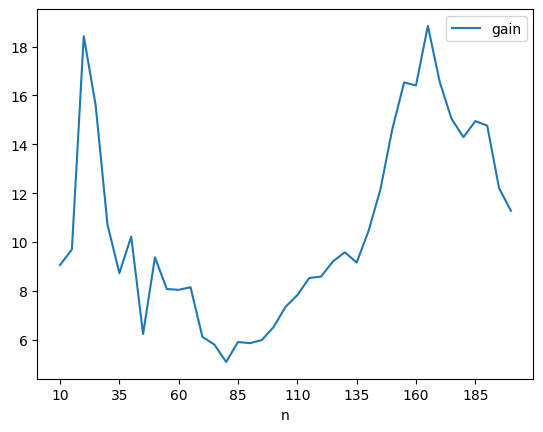

In [13]:
results.plot(x='n',y='gain')